# Multi-class Classification and Neural Networks

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io  # Used to load the OCTAVE *.mat files

import scipy.misc                # Used to show matrix as an image
import matplotlib.cm as cm       # Used to display images in a specific colormap
import random
from scipy.special import expit  # Vectorized sigmoid function

## Visualize the data

In [89]:
def ndarray_description(x):
    return "shape: {}, min: {}, max: {}".format(x.shape, x.min(), x.max())

In [85]:
datafile = 'data/ex3data1.mat'
mat = scipy.io.loadmat(datafile)
X, y = mat['X'], mat['y']

# insert column of ones
X = np.insert(X, 0, 1, axis=1)

print("X dimensions:", X.shape)  # 5000 images with 400 pixels (20x20)
print("y dimensions:", y.shape)  # Labeled classification 1-10, 10 represents 0

X dimensions: (5000, 401)
y dimensions: (5000, 1)


In [90]:
print("X", ndarray_description(X))
print("y", ndarray_description(y))

X shape: (5000, 401), min: -0.13196323019852488, max: 1.127688299158888
y shape: (5000, 1), min: 1, max: 10


(-0.5, 399.5, 19.5, -0.5)

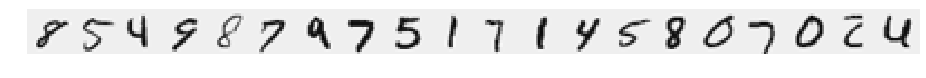

In [41]:
sample = np.random.choice(X.shape[0], 20)  # 20 row indices from X

fig, ax = plt.subplots(figsize=(16, 2))
ax.imshow(X[sample, 1:].reshape(-1,20).T, cmap='gray_r')  # 0 index is 1 constant
ax.axis('off')

## Multi-class Classification

#### Logistic regression hypothesis
#### $$ h_{\theta}(x) = g(\theta^{T}x)$$
#### $$ g(z)=\frac{1}{1+e^{−z}} $$

In [42]:
def hypothesis(theta, X):
    """Vectorized computation of the hypothesis for each example X with a set of theta values.
    
    X dot-product theta takes 401 x(i) values in a row of X (a vector) and
    multiples them with the 401 theta vector values. A.t * B = B.t * A if both are 
    vectors, so this vectorizes the g(theta.t * x) logistic hypothesis for all 5000
    examples in X.
    
    :param numpy.ndarray theta: 401x1 vector of theta values
    :param numpy.ndarray X: 5000x401 matrix of examples
    """
    return expit(np.dot(X, theta))

#### Regularized Cost Function 
#### $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\big[-y^{(i)}\, log\,( h_\theta\,(x^{(i)}))-(1-y^{(i)})\,log\,(1-h_\theta(x^{(i)}))\big] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$
#### Vectorized Cost Function
#### $$ J(\theta) = \frac{1}{m}\big((\,log\,(g(X\theta))^Ty+(\,log\,(1-g(X\theta))^T(1-y)\big) + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$

In [121]:
initial_theta = np.random.uniform(X.min(), X.max(), (X.shape[1], 1))  # 401x1
print("initial_theta", ndarray_description(initial_theta))

initial_theta shape: (401, 1), min: -0.12868200864051357, max: 1.1264524126137805


In [91]:
h = hypothesis(initial_theta, X)  # 5000x1
print("h", ndarray_description(h))

h shape: (5000, 1), min: 0.9993053937282703, max: 1.0


In [50]:
def cost(theta, X, y, learning_rate=0.): 
    """Calculate the total cost for every example with a set of parameter values.
    
    Set learning_rate to non-zero to include regularization.

    :param numpy.ndarray theta: An n- dimensional vector of initial parameter values
    :param numpy.ndarray X: An array of examples with n columns and m rows
    :param numpy.ndarray y: The labeled prediction, m rows and 1 column
    :param float learning_rate: parameter to tune the weight regularization holds on the cost function
    
    :rtype: float
    """
    m = len(y)  # 5000
    h = hypothesis(theta, X)  # 5000x1 vector
    
    term1 = np.log(h).dot(-y.T)     # 5000x5000
    term2 = np.log(1-h).dot(1-y.T)  # 5000x5000
    sumnation = term1 - term2       # 5000x5000
    reg = theta.T.dot(theta) * learning_rate/(2*m)  # 1x1. theta.dot(theta) squares the vector
    
    return sumnation + reg          # 5000x5000

In [102]:
c = cost(initial_theta, X, y)  # 5000x5000
print("c shape:", c.shape, "c[0] min:", c[0].min(), "c[0] max:", c[0].max())

/Users/joeselvik/.virtualenvs/machine-learning-coursera/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


c shape: (5000, 5000) c[0] min: -1.8345325258906746e-11 c[0] max: 7717.042017697812


#### Regularized Gradient

#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})x^{(i)}_{j} + \frac{\lambda}{m}\theta_{j}$$ 
#### ...vectorized
#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m} X^T(g(X\theta)-y) + \frac{\lambda}{m}\theta_{j}$$
##### $$\text{Note: intercept parameter } \theta_{0} \text{ is not to be regularized}$$

In [117]:
(hypothesis(initial_theta, X) - y.T).shape

(5000, 5000)

In [120]:
initial_theta[1:].shape

(400, 1)

In [124]:
def cost_gradient(theta, X, y, learning_rate=0.):
    m = len(y)                         # 5000
    beta = hypothesis(theta, X) - y.T  # 5000x1 - 1x5000, numpy broadcasting = 5000x5000
    reg = theta[1:]*(learning_rate/m)  # 400x1
    
    grad = (1./m) * np.dot(X.T, beta)  # 401x5000
    grad[1:] = grad[1:] + reg          # add reg to 1-401, not 0
    return grad                        # 401x5000

In [126]:
g = cost_gradient(initial_theta, X, y)
g.shape

(401, 5000)